In [1]:
#https://github.com/Lasagne/Recipes/blob/master/examples/styletransfer/Art%20Style%20Transfer.ipynb
import theano.tensor as T 
import theano
import numpy
from theano.tensor.nnet import relu,conv2d
import h5py
from theano.tensor.signal.pool import pool_2d
import scipy.misc
import numpy as np
from scipy.optimize import minimize
import skimage.transform
%matplotlib inline
import matplotlib.pyplot as plt
import skimage.transform

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5005)


In [2]:

class ConvLayer(object):
	"""Convolutional layer"""

	def __init__(self, rng, input, filter_shape, image_shape, W=None, b=None, padding=(1,1)):
		"""
		Allocate a LeNetConvPoolLayer with shared variable internal parameters.

		:type rng: numpy.random.RandomState
		:param rng: a random number generator used to initialize weights

		:type input: theano.tensor.dtensor4
		:param input: symbolic image tensor, of shape image_shape

		:type filter_shape: tuple or list of length 4
		:param filter_shape: (number of filters, num input feature maps,
		                      filter height, filter width)

		:type W: in accordance to filter_shape
		:param: use pretrained VGG weights

		:type b: (filter_shape[0],)
		:param: use pretrained vgg weights

		:type image_shape: tuple or list of length 4
		:param image_shape: (batch size, num input feature maps,
		                     image height, image width)

		:type padding: tuple or list of length 2
		:param padding: padding for conv
		"""

		assert image_shape[1] == filter_shape[1]
		self.input = input

		if W is None:
			# there are "num input feature maps * filter height * filter width"
			# inputs to each hidden unit
			fan_in = numpy.prod(filter_shape[1:])
			# each unit in the lower layer receives a gradient from:
			# "num output feature maps * filter height * filter width" /
			#   pooling size
			fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:]))
			# initialize weights with random weights
			W_bound = numpy.sqrt(6. / (fan_in + fan_out))
			self.W = theano.shared(
			    numpy.asarray(
			        rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
			        dtype=theano.config.floatX), borrow=True)
		else:
			self.W = theano.shared(W,borrow=True)

		if b is None:
			# the bias is a 1D tensor -- one bias per output feature map
			b_values = numpy.zeros((filter_shape[0],), dtype=theano.config.floatX)
			self.b = theano.shared(value=b_values, borrow=True)
		else:
			self.b = theano.shared(b,borrow=True)
        # convolve input feature maps with filters
		conv_out = conv2d(
		    input=input,
		    filters=self.W,
		    filter_shape=filter_shape,
		    input_shape=image_shape,
		    border_mode=padding
		)

		# add the bias term. Since the bias is a vector (1D array), we first
		# reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
		# thus be broadcasted across mini-batches and feature map
		# width & height
		self.output = relu(conv_out + self.b.dimshuffle('x', 0, 'x', 'x'))


In [3]:
#load the content image and the art image
content = plt.imread('content01.jpg')
art = plt.imread('style01.jpg')
# make the input image in a smaller dimention
# content = skimage.transform.resize(content,(400,400,3),preserve_range=True)
#get the height and width of the original image, the dim is (height,width,3)
height = content.shape[0]
width = content.shape[1]
#reshape the art image to match the content image
art = skimage.transform.resize(art,(height,width,3),preserve_range=True)


In [4]:
#minus a mean value of the picture to get better results
IMAGE_MEAN = np.array([104, 117, 124]).reshape((1,1,3))
content = content - IMAGE_MEAN	
art = art - IMAGE_MEAN

In [5]:
image = T.tensor3('image')
mode = 'average_exc_pad'
#load the weights of vgg19
vgg_weights = h5py.File("vgg19_weights.h5","r")
#reshape the image
image1 = image.reshape((1,height,width,3))
image2 = np.transpose(image1,(0,3,1,2))
#build the model
rng = numpy.random.RandomState(8888)
g = vgg_weights['layer_1']
conv1_1 = ConvLayer(rng=rng, input=image2, filter_shape=(64,3,3,3), 
	image_shape=(1,3,height,width),W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_3']
conv1_2 = ConvLayer(rng=rng, input=conv1_1.output,filter_shape=(64,64,3,3),
	image_shape=(1,64,height,width),W=g['param_0'].value,b=g['param_1'].value, padding=(1,1))
conv1_pool = pool_2d(conv1_2.output,ds=(2,2),padding=(0,0),mode=mode,ignore_border=True)

g = vgg_weights['layer_6']
conv2_1 = ConvLayer(rng=rng, input=conv1_pool, filter_shape=(128,64,3,3),
	image_shape=(1,64,height/2,width/2),W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_8']
conv2_2 = ConvLayer(rng=rng, input=conv2_1.output, filter_shape=(128,128,3,3),
	image_shape=(1,128,height/2,width/2),W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
conv2_pool = pool_2d(conv2_2.output,ds=(2,2),padding=(0,0),mode=mode,ignore_border=True)

g = vgg_weights['layer_11']
conv3_1 = ConvLayer(rng=rng, input=conv2_pool, filter_shape=(256,128,3,3),
	image_shape=(1,128,height/4,width/4),W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_13']
conv3_2 = ConvLayer(rng=rng, input=conv3_1.output, filter_shape=(256,256,3,3),
	image_shape=(1,256,height/4,width/4),W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_15']
conv3_3 = ConvLayer(rng=rng, input=conv3_2.output, filter_shape=(256,256,3,3),
	image_shape=(1,256,height/4,width/4),W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_17']
conv3_4 = ConvLayer(rng=rng, input=conv3_3.output, filter_shape=(256,256,3,3),
	image_shape=(1, 256,height/4,width/4),W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
conv3_pool = pool_2d(conv3_4.output,ds=(2,2),padding=(0,0),mode=mode,ignore_border=True)

g = vgg_weights['layer_20']
conv4_1 = ConvLayer(rng=rng, input=conv3_pool, filter_shape=(512,256,3,3),
	image_shape=(1,256,height/8,width/8),W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_22']
conv4_2 = ConvLayer(rng=rng, input=conv4_1.output, filter_shape=(512,512,3,3),
	image_shape=(1,512,height/8,width/8),W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_24']
conv4_3 = ConvLayer(rng=rng, input=conv4_2.output, filter_shape=(512,512,3,3),
	image_shape=(1,512,height/8,width/8),W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_26']
conv4_4 = ConvLayer(rng=rng, input=conv4_3.output, filter_shape=(512,512,3,3),
	image_shape=(1,512,height/8,width/8),W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
conv4_pool = pool_2d(conv4_4.output,ds=(2,2),padding=(0,0),mode=mode,ignore_border=True)

g = vgg_weights['layer_29']
conv5_1 = ConvLayer(rng=rng, input=conv4_pool, filter_shape=(512,512,3,3),
	image_shape=(1,512,height/16,width/16),W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_31']
conv5_2 = ConvLayer(rng=rng, input=conv5_1.output, filter_shape=(512,512,3,3),
	image_shape=(1,512,height/16,width/16),W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_33']
conv5_3 = ConvLayer(rng=rng, input=conv5_2.output, filter_shape=(512,512,3,3),
	image_shape=(1,512,height/16,width/16),W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_35']
conv5_4 = ConvLayer(rng=rng, input=conv5_3.output, filter_shape=(512,512,3,3),
	image_shape=(1,512,height/16,width/16),W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
conv5_pool = pool_2d(conv5_4.output,ds=(2,2),padding=(0,0),mode=mode,ignore_border=True)


In [6]:

#functions to calculate loss

def gramMatrix(layer_output):
    layer_output = layer_output.reshape((layer_output.shape[1],-1))
    return T.dot(layer_output,layer_output.T)

#loss function of the content image
	#output is the output of the image generated,content_output is the output of the content
def imageLoss(output,content_output):
    loss = 1./2 * ((output - content_output)**2).sum()
    return loss

In [7]:

#loss function of the art image
	#output is the output of the image generated,content_output is the output of the content
def artLoss(output,art_output):
    o1 = gramMatrix(output)
    o2 = gramMatrix(art_output)
    H = output.shape[1]
    M = output.shape[2] * output.shape[3]
    loss = 1./(4 * H**2 * M**2) * T.sum((o1 - o2)**2)
    return loss

#layers used to do content and style representation
artLayers = [conv1_1,conv3_1,conv5_1]
contentLayers = [conv4_2]

#calculate the content result
contentFunction = theano.function(inputs=[image],outputs=[contentLayers[0].output])
contentResult = theano.shared(np.asarray(contentFunction(np.asarray(content,
	dtype='float32'))[0],dtype='float32'))

#calculate the art result
artResults = []
for layer in artLayers:
    f = theano.function(inputs=[image],outputs=[layer.output])
    artResults.append(theano.shared(np.asarray(f(np.asarray(art,
            dtype='float32'))[0],dtype='float32')))


In [8]:

#use a randomized image as the input
initialImage = np.random.uniform(-126.0,127.0,size=(height,width,3))
inputImage = theano.shared(np.asarray(initialImage,dtype='float32'),borrow=True)


In [9]:

#the results we get by using the randomized image as input
inputContent = contentLayers[0].output
inputArts = []
for layer in artLayers:
    inputArts.append(layer.output)

In [10]:

#We choose different alpha and beta here to calculate the cost function
losses = []
losses.append(0.001*imageLoss(inputContent,contentResult))
for i in xrange(len(inputArts)):
    losses.append(0.2e6*artLoss(inputArts[i],artResults[i]))
totalLoss = T.sum(losses)

In [11]:

grad = T.grad(totalLoss, image)
theanoLoss = theano.function([image], totalLoss, allow_input_downcast=True)
theanoGrad = theano.function([image], grad, allow_input_downcast=True)


In [12]:

# minimize the loss function using the optimizing function in scipy and use L-BFGS
def sciLoss(x):
    x = np.float32(x.reshape(height,width,3))
    inputImage.set_value(x)
    return theanoLoss(inputImage.get_value()).astype('float64')

def sciGrad(x):
    x = np.float32(x.reshape(height,width,3))
    inputImage.set_value(x)
    return np.ravel(theanoGrad(inputImage.get_value())).astype('float64')


In [13]:
n_epochs = 50
temp = inputImage.get_value()
for epoch in xrange(n_epochs):
    #print epoch
    minimize(fun=sciLoss, x0=np.ravel(inputImage.get_value()).astype('float64'), jac=sciGrad,
         method='L-BFGS-B',options={'disp':True,'maxfun':40,'maxiter':15000})
    #print theanoLoss(inputImage.get_value())


(-0.5, 874.5, 674.5, -0.5)

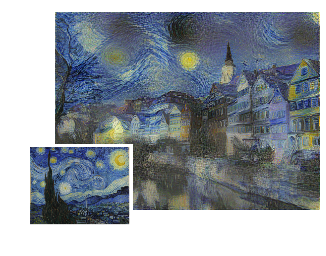

In [15]:
plt.imshow(np.clip(inputImage.get_value()+IMAGE_MEAN, 0, 255).astype('uint8'))

(-0.5, 874.5, 674.5, -0.5)

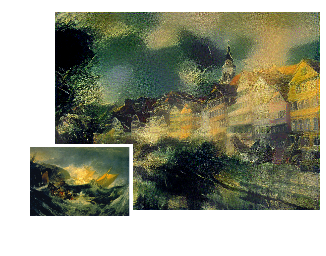

In [16]:
plt.imshow(np.clip(inputImage.get_value()+IMAGE_MEAN, 0, 255).astype('uint8'))